## Load Data, Get Representation, Train Binary Classification RNN Model
(Binary classification on log fold change)

In [1]:
import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

reload(data_loading)
reload(experiment)
reload(rnn)
reload(umap)

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'analysis.umap_analysis' from '/Users/choyl/Src/ml_phage_display-main_v2/src/analysis/umap_analysis.py'>

In [2]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "12ca5"
other_protein = "MDM2"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

In [3]:
y_f = y[:,1]>0
y_p = y[:,0]

result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y_f, rnn.BinaryClassificationRNN
)

Epoch 1/16


2023-01-04 15:17:15.930782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


206/206 [==============================] - 5s 7ms/step - loss: 0.5978 - accuracy: 0.7135 - recall: 0.0852 - precision: 0.4227
Epoch 2/16
206/206 [==============================] - 1s 6ms/step - loss: 0.5351 - accuracy: 0.7647 - recall: 0.2161 - precision: 0.7742
Epoch 3/16
206/206 [==============================] - 1s 6ms/step - loss: 0.5265 - accuracy: 0.7710 - recall: 0.2278 - precision: 0.8143
Epoch 4/16
206/206 [==============================] - 1s 5ms/step - loss: 0.5220 - accuracy: 0.7745 - recall: 0.2376 - precision: 0.8288
Epoch 5/16
206/206 [==============================] - 1s 5ms/step - loss: 0.5139 - accuracy: 0.7822 - recall: 0.2586 - precision: 0.8592
Epoch 6/16
206/206 [==============================] - 1s 5ms/step - loss: 0.5092 - accuracy: 0.7846 - recall: 0.2652 - precision: 0.8672
Epoch 7/16
206/206 [==============================] - 1s 5ms/step - loss: 0.5043 - accuracy: 0.7877 - recall: 0.2705 - precision: 0.8863
Epoch 8/16
206/206 [==============================] 

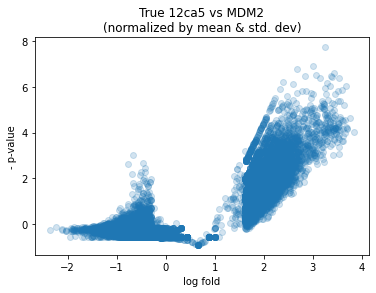

In [4]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], -y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [5]:
model =result.trained_model

In [6]:
kf = KFold(n_splits=5)
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_f_train, y_f_test = y[:,1][train_index], y[:,1][test_index]
    y_p_train, y_p_test = y[:,0][train_index], y[:,0][test_index]
    
    if i==0:
        break
    i += 1       

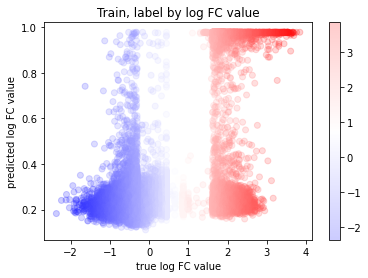

In [7]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true log FC value")
plt.scatter(y_f_train, model(X_train), c=y_f_train, cmap='bwr',alpha=0.2)
plt.title("Train, label by log FC value")
plt.colorbar()
plt.show()

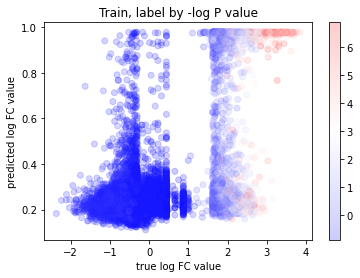

In [8]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true log FC value")
plt.scatter(y_f_train, model(X_train), c=-y_p_train, cmap='bwr',alpha=0.2)
plt.title("Train, label by -log P value")
plt.colorbar()
plt.show()

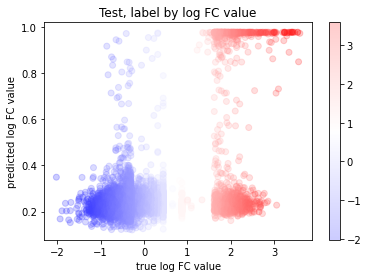

In [9]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true log FC value")
plt.scatter(y_f_test, model(X_test), c=y_f_test, cmap='bwr',alpha=0.2)
plt.title("Test, label by log FC value")
plt.colorbar()
plt.show()

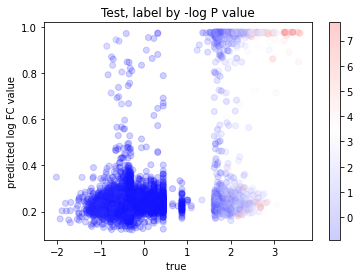

In [10]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true ")
plt.scatter(y_f_test, model(X_test), c=-y_p_test, cmap='bwr',alpha=0.2)
plt.title("Test, label by -log P value")
plt.colorbar()
plt.show()

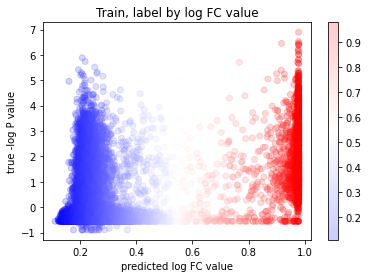

In [11]:
#Train samples classification results 
plt.ylabel("true -log P value")
plt.xlabel("predicted log FC value")
plt.scatter(model(X_train), -y_p_train ,c=model(X_train), cmap='bwr',alpha=0.2)
plt.title("Train, label by log FC value")
plt.colorbar()
plt.show()

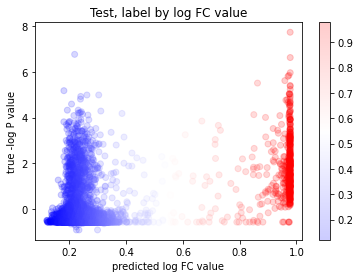

In [12]:
#Train samples classification results 
plt.ylabel("true -log P value")
plt.xlabel("predicted log FC value")
plt.scatter(model(X_test), -y_p_test ,c=model(X_test), cmap='bwr',alpha=0.2)
plt.title("Test, label by log FC value")
plt.colorbar()
plt.show()

In [13]:
y_train_pred = model(X_train)>= 0.5
tn, fp, fn, tp = confusion_matrix(y_f_train>0, y_train_pred).ravel()

acc, pre, rec = [], [], []
print(tn, fp, fn, tp)
print("accuracy", (tn+tp)/(tn+fp+fn+tp))
acc.append((tn+tp)/(tn+fp+fn+tp))
print("precision", tp/(tp+fp))
pre.append(tp/(tp+fp))
print("recall", tp/(tp+fn))
rec.append(tp/(tp+fn))

18851 185 5191 2101
accuracy 0.7958067456700091
precision 0.9190726159230096
recall 0.2881239714755897


In [14]:
embedding=umap.embedding_classification(model,X_train)

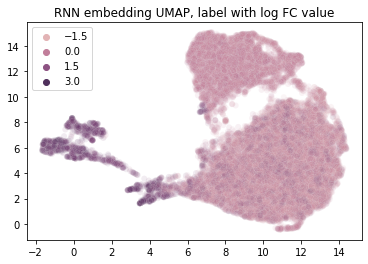

In [19]:
umap.UMAP_log_Fold(embedding, y_f_train)

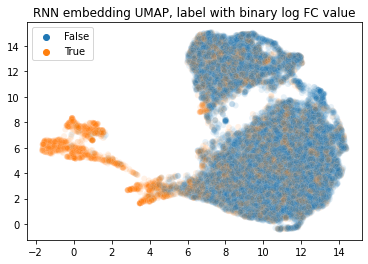

In [20]:
umap.UMAP_binary_log_Fold(embedding, y_f_train)

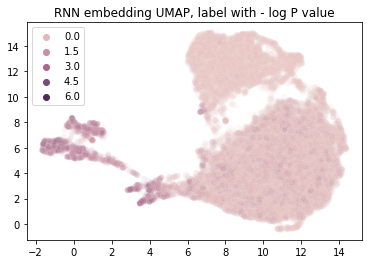

In [21]:
umap.UMAP_log_P(embedding, y_p_train)

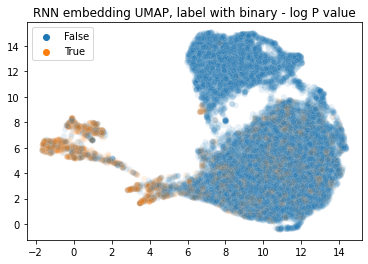

In [22]:
umap.UMAP_binary_log_P(embedding, y_p_train)

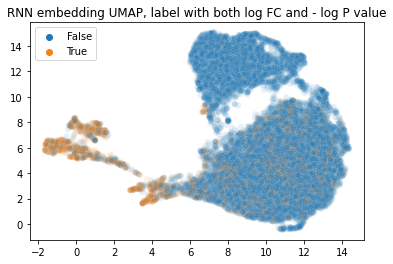

In [23]:
umap.UMAP_joint(embedding, y_f_train,y_p_train)

## Load Data, Get Representation, Train Binary Classification RNN Model, CrossFold Best Model¶
(Binary classification on log fold change)

In [24]:
y_fc = y[:,1]>0
y_p = y[:,0]

result1 = experiment.BinaryClassificationExperiment().run_cross_validation_experiment(
    X, y_fc, rnn.BinaryClassificationRNN
)

Epoch 1/16
206/206 [==============================] - 4s 5ms/step - loss: 0.5458 - accuracy: 0.7577 - recall_1: 0.1731 - precision_1: 0.7829
Epoch 2/16
206/206 [==============================] - 1s 6ms/step - loss: 0.5146 - accuracy: 0.7801 - recall_1: 0.2433 - precision_1: 0.8675
Epoch 3/16
206/206 [==============================] - 1s 6ms/step - loss: 0.5045 - accuracy: 0.7872 - recall_1: 0.2649 - precision_1: 0.8883
Epoch 4/16
206/206 [==============================] - 1s 5ms/step - loss: 0.5004 - accuracy: 0.7901 - recall_1: 0.2699 - precision_1: 0.9073
Epoch 5/16
206/206 [==============================] - 1s 5ms/step - loss: 0.4971 - accuracy: 0.7919 - recall_1: 0.2745 - precision_1: 0.9137
Epoch 6/16
206/206 [==============================] - 1s 5ms/step - loss: 0.4956 - accuracy: 0.7933 - recall_1: 0.2777 - precision_1: 0.9209
Epoch 7/16
206/206 [==============================] - 1s 5ms/step - loss: 0.4929 - accuracy: 0.7948 - recall_1: 0.2807 - precision_1: 0.9288
Epoch 8/16
20

In [ ]:
model =result1[0].trained_model

In [25]:
kf = KFold(n_splits=5)
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_f_train, y_f_test = y[:,1][train_index], y[:,1][test_index]
    y_p_train, y_p_test = y[:,0][train_index], y[:,0][test_index]
    
    if i==0:
        break
    i += 1       

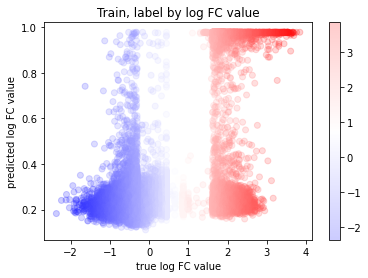

In [26]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true log FC value")
plt.scatter(y_f_train, model(X_train), c=y_f_train, cmap='bwr',alpha=0.2)
plt.title("Train, label by log FC value")
plt.colorbar()
plt.show()

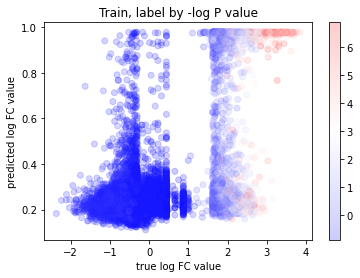

In [27]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true log FC value")
plt.scatter(y_f_train, model(X_train), c=-y_p_train, cmap='bwr',alpha=0.2)
plt.title("Train, label by -log P value")
plt.colorbar()
plt.show()

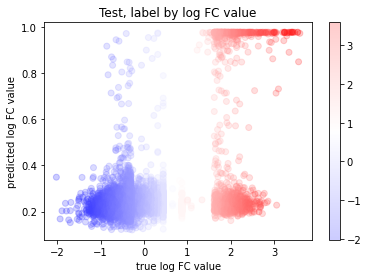

In [28]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true log FC value")
plt.scatter(y_f_test, model(X_test), c=y_f_test, cmap='bwr',alpha=0.2)
plt.title("Test, label by log FC value")
plt.colorbar()
plt.show()

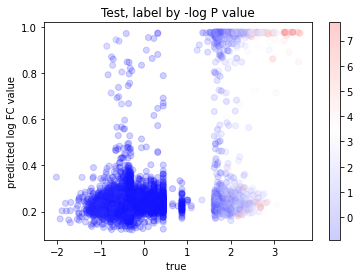

In [29]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true ")
plt.scatter(y_f_test, model(X_test), c=-y_p_test, cmap='bwr',alpha=0.2)
plt.title("Test, label by -log P value")
plt.colorbar()
plt.show()

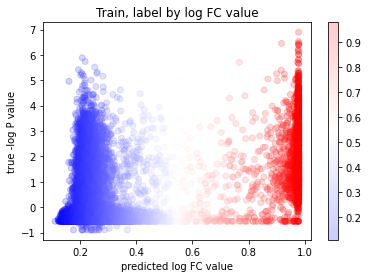

In [30]:
#Train samples classification results 
plt.ylabel("true -log P value")
plt.xlabel("predicted log FC value")
plt.scatter(model(X_train), -y_p_train ,c=model(X_train), cmap='bwr',alpha=0.2)
plt.title("Train, label by log FC value")
plt.colorbar()
plt.show()

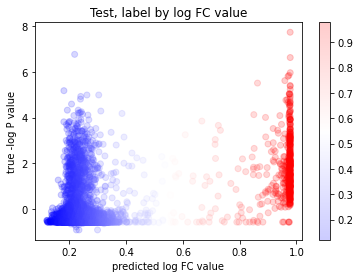

In [31]:
#Train samples classification results 
plt.ylabel("true -log P value")
plt.xlabel("predicted log FC value")
plt.scatter(model(X_test), -y_p_test ,c=model(X_test), cmap='bwr',alpha=0.2)
plt.title("Test, label by log FC value")
plt.colorbar()
plt.show()

In [32]:
y_train_pred = model(X_train)>= 0.5
tn, fp, fn, tp = confusion_matrix(y_f_train>0, y_train_pred).ravel()

acc, pre, rec = [], [], []
print(tn, fp, fn, tp)
print("accuracy", (tn+tp)/(tn+fp+fn+tp))
acc.append((tn+tp)/(tn+fp+fn+tp))
print("precision", tp/(tp+fp))
pre.append(tp/(tp+fp))
print("recall", tp/(tp+fn))
rec.append(tp/(tp+fn))

18851 185 5191 2101
accuracy 0.7958067456700091
precision 0.9190726159230096
recall 0.2881239714755897


In [33]:
embedding=umap.embedding_classification(model,X_train)

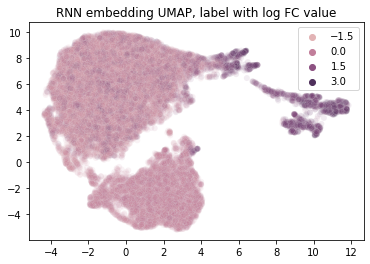

In [34]:
umap.UMAP_log_Fold(embedding, y_f_train)

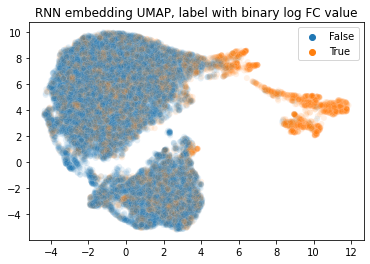

In [35]:
umap.UMAP_binary_log_Fold(embedding, y_f_train)

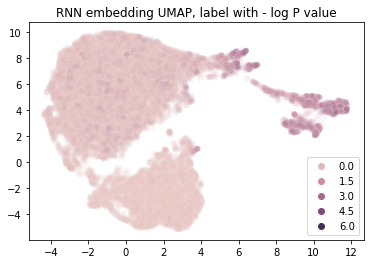

In [36]:
umap.UMAP_log_P(embedding, y_p_train)

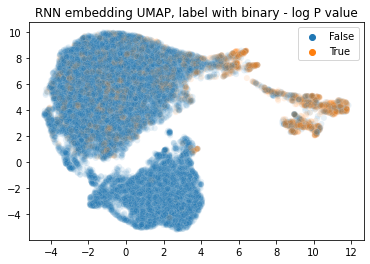

In [37]:
umap.UMAP_binary_log_P(embedding, y_p_train)

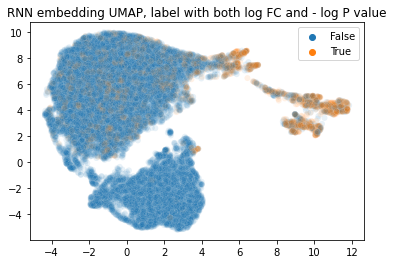

In [38]:
umap.UMAP_joint(embedding, y_f_train,y_p_train)

[(-4.0, 0.0)]

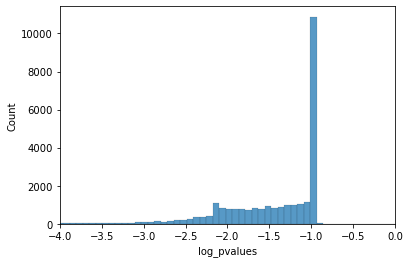

In [43]:
g=sns.histplot(R3_lib['log_pvalues'])
g.set(xlim=(-4,0))

<AxesSubplot: xlabel='log_pvalues', ylabel='Count'>

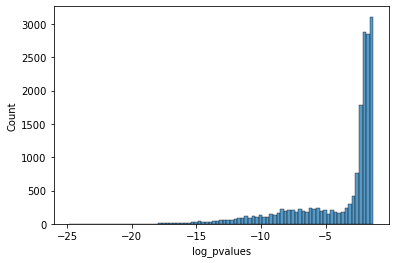

In [46]:
log_pvalues_cutoff = -R3_lib['log_pvalues'] > -np.log10(0.05)
sns.histplot(R3_lib.loc[log_pvalues_cutoff==True]['log_pvalues'])

In [54]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] >0:
        if -y_p_train[i]>-np.log10(0.05):
            if x1 >5.0:
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [55]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [56]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('ACW', 65),
 ('ACG', 68),
 ('DLR', 70),
 ('PDY', 70),
 ('ECR', 77),
 ('CGD', 84),
 ('LGD', 88),
 ('YAA', 92),
 ('RDY', 95),
 ('AAC', 97),
 ('LEC', 113),
 ('DYS', 121),
 ('YAC', 234),
 ('GDY', 403),
 ('DYA', 431)]

In [57]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 431)
('GDY', 403)
('YAC', 234)
('DYS', 121)
('LEC', 113)


## Load Data, Get Representation, Train single regression RNN Model

In [27]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "12ca5"
other_protein = "MDM2"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

In [28]:
y_f = y[:,1]>0
y_p = y[:,0]

result2 = experiment.SingleRegressionExperiment().run_adhoc_experiment(
    X, y_f, rnn.SingleRegressionRNN
)

Epoch 1/16
186/186 [==============================] - 11s 57ms/step - loss: 0.2134 - fold_rmse: 0.2133 - val_loss: 0.1924 - val_fold_rmse: 0.1920 - lr: 4.0657e-04
Epoch 2/16
186/186 [==============================] - 10s 55ms/step - loss: 0.1846 - fold_rmse: 0.1849 - val_loss: 0.1846 - val_fold_rmse: 0.1840 - lr: 4.0657e-04
Epoch 3/16
186/186 [==============================] - 11s 57ms/step - loss: 0.1794 - fold_rmse: 0.1795 - val_loss: 0.1794 - val_fold_rmse: 0.1787 - lr: 4.0657e-04
Epoch 4/16
186/186 [==============================] - 10s 55ms/step - loss: 0.1756 - fold_rmse: 0.1758 - val_loss: 0.1753 - val_fold_rmse: 0.1745 - lr: 4.0657e-04
Epoch 5/16
186/186 [==============================] - 10s 54ms/step - loss: 0.1740 - fold_rmse: 0.1740 - val_loss: 0.1737 - val_fold_rmse: 0.1729 - lr: 4.0657e-04
Epoch 6/16
186/186 [==============================] - 10s 56ms/step - loss: 0.1727 - fold_rmse: 0.1728 - val_loss: 0.1702 - val_fold_rmse: 0.1696 - lr: 3.6788e-04
Epoch 7/16
186/186 [==

In [29]:
model =result2.trained_model

In [30]:
kf = KFold(n_splits=5)
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_f_train, y_f_test = y[:,1][train_index], y[:,1][test_index]
    y_p_train, y_p_test = y[:,0][train_index], y[:,0][test_index]
    
    if i==0:
        break
    i += 1      

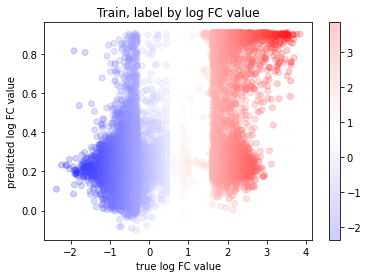

In [31]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true log FC value")
plt.scatter(y_f_train, model(X_train), c=y_f_train, cmap='bwr',alpha=0.2)
plt.title("Train, label by log FC value")
plt.colorbar()
plt.show()

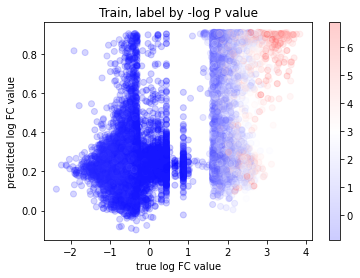

In [32]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true log FC value")
plt.scatter(y_f_train, model(X_train), c=-y_p_train, cmap='bwr',alpha=0.2)
plt.title("Train, label by -log P value")
plt.colorbar()
plt.show()

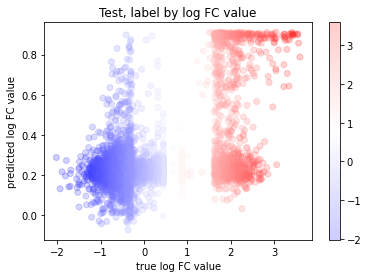

In [33]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true log FC value")
plt.scatter(y_f_test, model(X_test), c=y_f_test, cmap='bwr',alpha=0.2)
plt.title("Test, label by log FC value")
plt.colorbar()
plt.show()

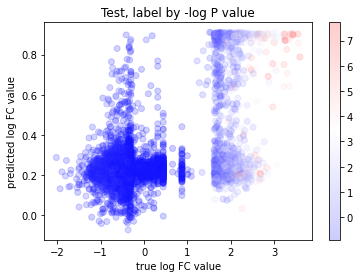

In [34]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true log FC value")
plt.scatter(y_f_test, model(X_test), c=-y_p_test, cmap='bwr',alpha=0.2)
plt.title("Test, label by -log P value")
plt.colorbar()
plt.show()

In [35]:
y_train_pred = model(X_train)>= 0.5
tn, fp, fn, tp = confusion_matrix(y_f_train>0, y_train_pred).ravel()

acc, pre, rec = [], [], []
print(tn, fp, fn, tp)
print("accuracy", (tn+tp)/(tn+fp+fn+tp))
acc.append((tn+tp)/(tn+fp+fn+tp))
print("precision", tp/(tp+fp))
pre.append(tp/(tp+fp))
print("recall", tp/(tp+fn))
rec.append(tp/(tp+fn))

18703 333 5217 2075
accuracy 0.7891978122151322
precision 0.8617109634551495
recall 0.28455842018650573


In [36]:
embedding=umap.embedding_regression(model,X_train)

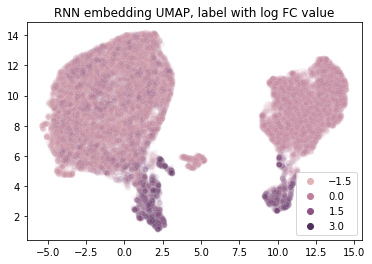

In [37]:
umap.UMAP_log_Fold(embedding, y_f_train)

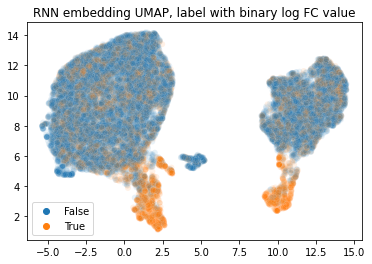

In [38]:
umap.UMAP_binary_log_Fold(embedding, y_f_train)

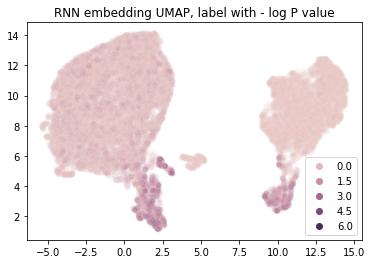

In [39]:
umap.UMAP_log_P(embedding, y_p_train)

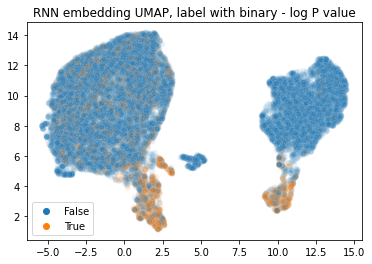

In [40]:
umap.UMAP_binary_log_P(embedding, y_p_train)

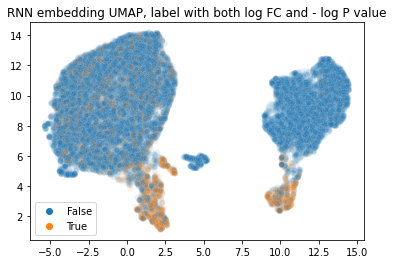

In [41]:
umap.UMAP_joint(embedding, y_f_train,y_p_train)

In [42]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] >0:
        if -y_p_train[i]>-np.log10(0.05):
            if x2 <4.0:
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [43]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [44]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('EDL', 50),
 ('AYC', 50),
 ('ACG', 53),
 ('LRD', 59),
 ('DLR', 64),
 ('PDY', 67),
 ('CGD', 74),
 ('LGD', 75),
 ('AAC', 75),
 ('YAA', 78),
 ('RDY', 89),
 ('DYS', 98),
 ('YAC', 222),
 ('GDY', 388),
 ('DYA', 419)]

In [45]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 419)
('GDY', 388)
('YAC', 222)
('DYS', 98)
('RDY', 89)


## Load Data, Get Representation, Train Joint Regression RNN Model
(Joint Regression on log fold change & p-value)

In [46]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "12ca5"
other_protein = "MDM2"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

In [47]:
result = experiment.RegressionExperiment().run_adhoc_experiment(
    X, y, rnn.RegressionRNN, load_trained_model=False
)

Epoch 1/16
186/186 [==============================] - 11s 59ms/step - loss: 0.9293 - two_channel_mse: 0.9293 - fold_rmse: 0.9282 - p_value_rmse: 0.9282 - val_loss: 1.0593 - val_two_channel_mse: 1.0593 - val_fold_rmse: 1.0551 - val_p_value_rmse: 1.0551 - lr: 0.0010
Epoch 2/16
186/186 [==============================] - 11s 57ms/step - loss: 0.8475 - two_channel_mse: 0.8475 - fold_rmse: 0.8447 - p_value_rmse: 0.8447 - val_loss: 0.9267 - val_two_channel_mse: 0.9267 - val_fold_rmse: 0.9229 - val_p_value_rmse: 0.9229 - lr: 0.0010
Epoch 3/16
186/186 [==============================] - 11s 58ms/step - loss: 0.7764 - two_channel_mse: 0.7764 - fold_rmse: 0.7748 - p_value_rmse: 0.7748 - val_loss: 0.7467 - val_two_channel_mse: 0.7467 - val_fold_rmse: 0.7418 - val_p_value_rmse: 0.7418 - lr: 0.0010
Epoch 4/16
186/186 [==============================] - 10s 56ms/step - loss: 0.7316 - two_channel_mse: 0.7316 - fold_rmse: 0.7323 - p_value_rmse: 0.7323 - val_loss: 0.7122 - val_two_channel_mse: 0.7122 - va

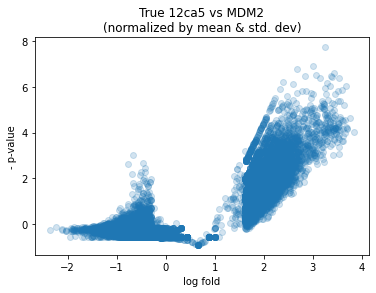

In [48]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], -y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

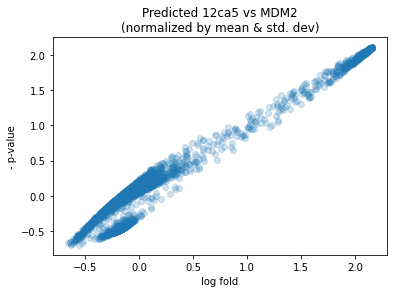

In [49]:
show_volcano(
    result.y_pred, protein_of_interest, other_protein, title_addendum="Predicted "
)

In [50]:
model =result.trained_model

In [51]:
kf = KFold(n_splits=5)
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_f_train, y_f_test = y[:,1][train_index], y[:,1][test_index]
    y_p_train, y_p_test = y[:,0][train_index], y[:,0][test_index]
    
    if i==0:
        break
    i += 1     

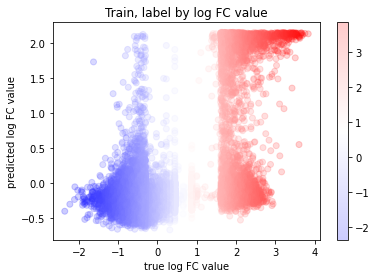

In [52]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true log FC value")
plt.scatter(y_f_train, model(X_train)[:,1], c=y_f_train, cmap='bwr',alpha=0.2)
plt.title("Train, label by log FC value")
plt.colorbar()
plt.show()

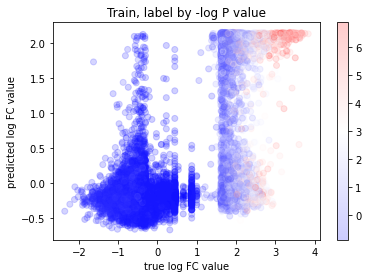

In [53]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true log FC value")
plt.scatter(y_f_train, model(X_train)[:,1], c=-y_p_train, cmap='bwr',alpha=0.2)
plt.title("Train, label by -log P value")
plt.colorbar()
plt.show()

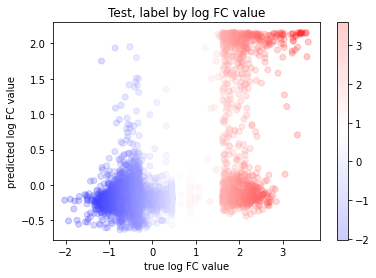

In [54]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true log FC value")
plt.scatter(y_f_test, model(X_test)[:,1], c=y_f_test, cmap='bwr',alpha=0.2)
plt.title("Test, label by log FC value")
plt.colorbar()
plt.show()

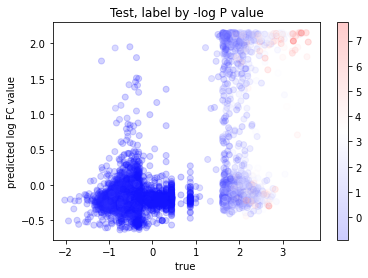

In [55]:
#Train samples classification results 
plt.ylabel("predicted log FC value")
plt.xlabel("true ")
plt.scatter(y_f_test, model(X_test)[:,1], c=-y_p_test, cmap='bwr',alpha=0.2)
plt.title("Test, label by -log P value")
plt.colorbar()
plt.show()

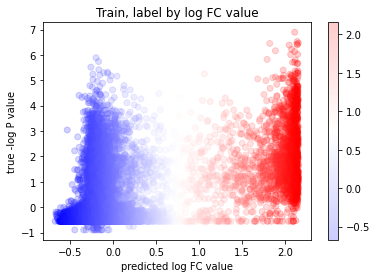

In [57]:
#Train samples classification results 
plt.ylabel("true -log P value")
plt.xlabel("predicted log FC value")
plt.scatter(model(X_train)[:,1], -y_p_train ,c=model(X_train)[:,1], cmap='bwr',alpha=0.2)
plt.title("Train, label by log FC value")
plt.colorbar()
plt.show()

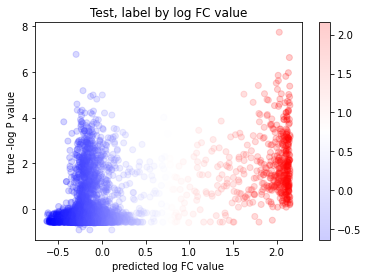

In [58]:
#Train samples classification results 
plt.ylabel("true -log P value")
plt.xlabel("predicted log FC value")
plt.scatter(model(X_test)[:,1], -y_p_test ,c=model(X_test)[:,1], cmap='bwr',alpha=0.2)
plt.title("Test, label by log FC value")
plt.colorbar()
plt.show()

In [60]:
embedding=umap.embedding_regression(model,X_train)

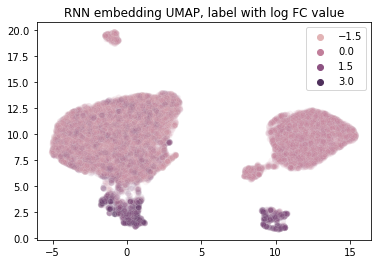

In [61]:
umap.UMAP_log_Fold(embedding, y_f_train)

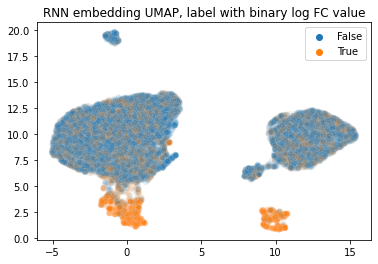

In [62]:
umap.UMAP_binary_log_Fold(embedding, y_f_train)

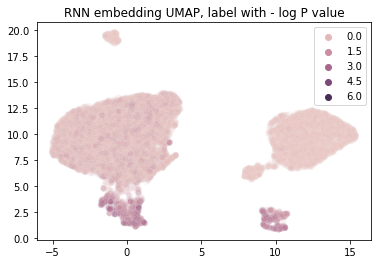

In [64]:
umap.UMAP_log_P(embedding, y_p_train)

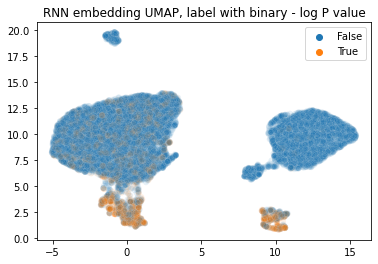

In [65]:
umap.UMAP_binary_log_P(embedding, y_p_train)

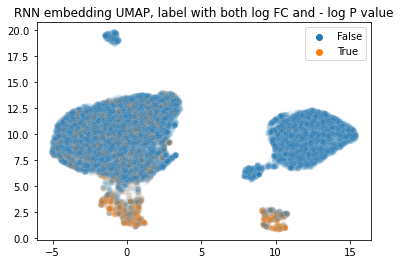

In [67]:
umap.UMAP_joint(embedding,y_f_train, y_p_train)

In [68]:
np.array(model(X_train)[:,0])>0
tn, fp, fn, tp = confusion_matrix((y_f_train>0)*(-y_p_train>-0.5), (np.array(model(X_train)[:,1])>0)*(-np.array(model(X_train)[:,0])>-0.5)).ravel()
acc, pre, rec = [], [], []
print(tn, fp, fn, tp)
print("accuracy", (tn+tp)/(tn+fp+fn+tp))
acc.append((tn+tp)/(tn+fp+fn+tp))
print("precision", tp/(tp+fp))
pre.append(tp/(tp+fp))
print("recall", tp/(tp+fn))
rec.append(tp/(tp+fn))

20159 1568 2055 2546
accuracy 0.8623898511090854
precision 0.6188624210014584
recall 0.5533579656596392


In [70]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] >0:
        if -y_p_train[i]>-np.log10(0.05):
            if x2 <4.0:
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [71]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [72]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('ACG', 66),
 ('LRD', 70),
 ('PDY', 72),
 ('ECR', 78),
 ('DLR', 81),
 ('CGD', 84),
 ('LGD', 91),
 ('YAA', 92),
 ('RDY', 96),
 ('AAC', 101),
 ('LEC', 116),
 ('DYS', 123),
 ('YAC', 230),
 ('GDY', 404),
 ('DYA', 428)]

In [73]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 428)
('GDY', 404)
('YAC', 230)
('DYS', 123)
('LEC', 116)


## Previous code

In [11]:
# Load other data libraries 
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
R2_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R2.csv")
R1_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R1.csv")

ImportError: cannot import name 'two_channel_mse' from 'models.rnn' (/Users/yitongtseo/Documents/GitHub/ml_phage_display/./src/models/rnn.py)

## Investigate Input Data

<AxesSubplot: xlabel='c_cnt', ylabel='Count'>

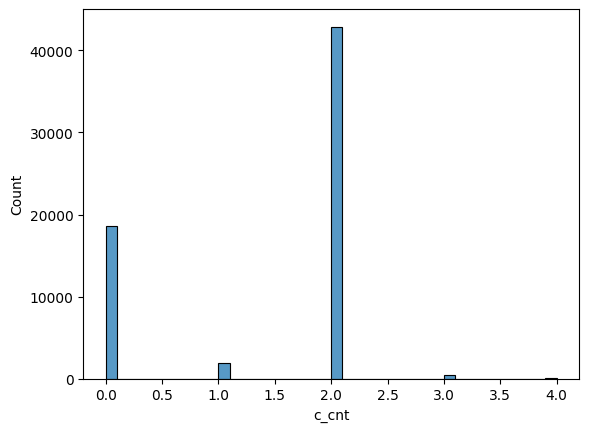

In [9]:
import seaborn as sns
sns.histplot(R3_lib['c_cnt'])

In [10]:
log_ratio_12ca5, _ = data_loading.build_dataset(R3_lib, protein_of_interest='12ca5')
sns.histplot(log_ratio_12ca5[R3_lib.is_dya==True], binwidth=0.2)
plt.title('DYA peptide')

IndexError: list index out of range

In [21]:
sns.histplot(log_ratio_12ca5[R3_lib.is_lle==True], binwidth=0.2, alpha=0.5)
plt.title('LLE peptide')

KeyError: '12ca5_log_ratio'

In [22]:
print((R3_lib.loc[R3_lib.is_lle==True]['12ca5_log_ratio']>0).sum())
print((R3_lib.loc[R3_lib.is_lle==True]['12ca5_log_ratio']<=0).sum())

KeyError: '12ca5_log_ratio'

Text(0.5, 1.0, 'all peptide')

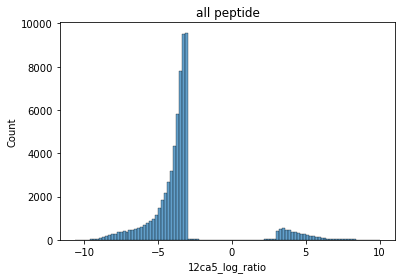

In [ ]:
sns.histplot(R3_lib['12ca5_log_ratio'], binwidth=0.2, alpha=0.7)
plt.title('all peptide')
# sns.histplot(R3_lib.loc[R3_lib.is_dya==True]['12ca5_log_ratio'], binwidth=0.2)

### model performance results

In [ ]:
print(acc)
print(pre)
print(rec)

[0.6483550832226304, 0.6542158318355865, 0.6634104407627384, 0.6598937167864958, 0.6517661769302907]
[0.6417112299465241, 0.6702702702702703, 0.6440677966101694, 0.7009803921568627, 0.751937984496124]
[0.026356248627278717, 0.027629233511586453, 0.026158788435061954, 0.03225078935498421, 0.021455430214554302]


In [ ]:
print(np.array(acc).mean(), np.array(acc).var())
print(np.array(pre).mean(), np.array(pre).var())
print(np.array(rec).mean(), np.array(rec).var())

0.6555282499075484 2.9703237664053927e-05
0.6817935346959902 0.0016901974856322836
0.026770098028693123 1.1913351182601678e-05


### umap

In [ ]:
# get the 4th fold because the 4th model showed the best precision
# actually unnecessary, can just use whatever fold
kf = KFold(n_splits=2)
i = 0
y_reg = np.array(list(y_reg))
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_reg_train, y_reg_test = y_reg[train_index], y_reg[test_index]
    if i==0:
        break
    i += 1

In [ ]:
embedding = reducer.fit_transform(nn_emb)

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

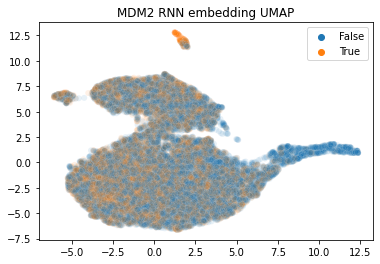

In [ ]:
# tests
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_train, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

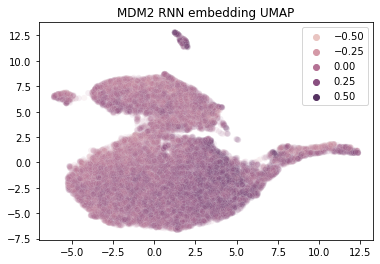

In [ ]:
# tests
X_train_prop1 = X_train[:,:,2].mean(-1)
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=X_train_prop1, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

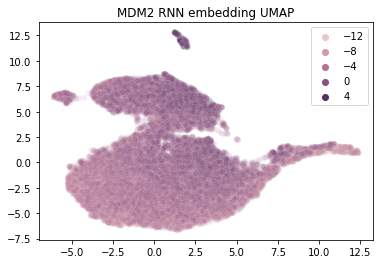

In [ ]:
# color by volume of side chain
X_train_prop2 = X_train[:,:,10].sum(-1)#.sum(-1)
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=X_train_prop2, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

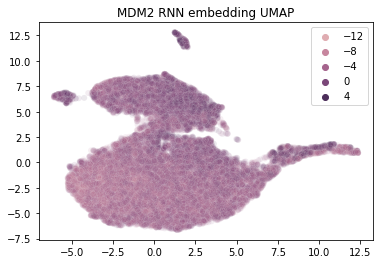

In [ ]:
# color by SASA
X_train_prop2 = X_train[:,:,9].sum(-1)#.sum(-1)
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=X_train_prop2, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

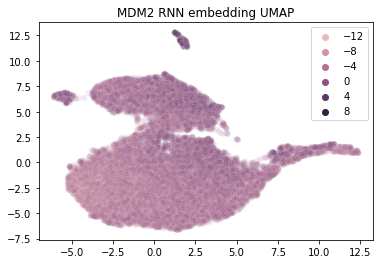

In [ ]:
# color by polarizability
X_train_prop2 = X_train[:,:,8].sum(-1)
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=X_train_prop2, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

In [ ]:
# write results
with open('mdm2_good.txt','w') as fh:
    for i in range(len(ls)):
        fh.write(f'{ls[i]}\n')

In [ ]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_train[i] == 1:
        if x2 > 10.0:
            true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [ ]:
good_seqs

['AFCDWFACY',
 'ACKPFMCWW',
 'AFCDWFKCN',
 'AFCDWYCCS',
 'ACSCFECFW',
 'AYCVWVWCS',
 'AFCDWLWCS',
 'AFCDRFWCS',
 'AFCYWCWCS',
 'AFCDGLWCS',
 'WSLNSGMFGYQW',
 'AFCDCVWCS',
 'AFCDCFLCS',
 'AFWDWFWCA',
 'ACVSFECFW',
 'AFCDWYECN',
 'ALCGFWFCD',
 'AFCVWFECY',
 'AFFDWFWCS',
 'ACECFSCWW',
 'ACSTFECWW',
 'ACKCFMCWW',
 'AYCYWFWCS',
 'ACMTFMCWC',
 'ACCDWFWCS',
 'AFKTFMCWW',
 'AFCFWFWCS',
 'ACDSFSCWW',
 'AFCDYFYCS',
 'AVCFLEWCS',
 'ALCVWVWCS',
 'AFCWFDSCQ',
 'AFCYLFWCS',
 'AFCDLFWCD',
 'ACETFMCWW',
 'AFCDWLWCP',
 'AYCVWFWCS',
 'AYCDWFECN',
 'ACMTFMCWW',
 'ACSTFEWFW',
 'AFFDCFWCS',
 'AFFAWFWCS',
 'AFCAWFWWS',
 'ACKTFLCWW',
 'AFCVWVWCC',
 'ACKTFMFWW',
 'ACTTFEWWW',
 'AFCVWFLCC',
 'AFCDWFVCY',
 'AFCVWFWRS',
 'ACYTFMCWW',
 'AFCYWVWCS',
 'AFCDWYWCS',
 'AYCDWFECN',
 'AFCVWVWGS',
 'AFCAWFWCS',
 'AFCDWVWCS',
 'ACWWWSYCS',
 'AFCVWVWCS',
 'AFWVWFWCS',
 'AFCDWFESN',
 'AFCVRFWCS',
 'ACYTFMCWW',
 'AFCDGVWCS',
 'AFCYWLWCS',
 'ALCDWFWCS',
 'AFCVWFWCS',
 'AFCDWFECY',
 'ACSPFECFW',
 'AFFFWFWCS',
 'AFCDWSWCS',
 'A

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

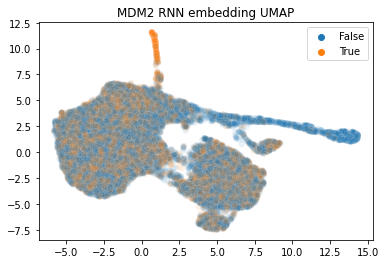

In [ ]:
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_train, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

### confidence analysis

In [ ]:
y_pred = model(X_train)

Text(0.5, 0, 'MDM2_log_ratio')

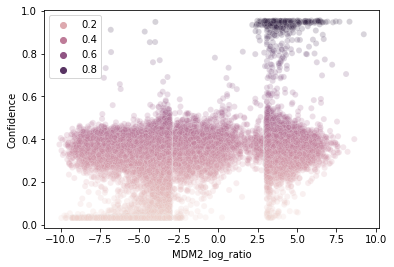

In [ ]:
# colored by predicted confidence
ax = sns.scatterplot(x=y_mdm2_reg_train, y=y_pred.numpy().reshape(-1), hue=y_pred.numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('MDM2_log_ratio')

Text(0.5, 0, 'MDM2_log_ratio')

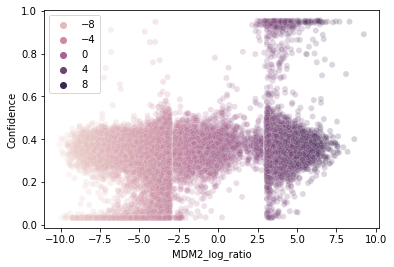

In [ ]:
# colored by true log ratio 
ax = sns.scatterplot(x=y_reg_train, y=y_pred.numpy().reshape(-1), hue=y_reg_train, alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('MDM2_log_ratio')

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

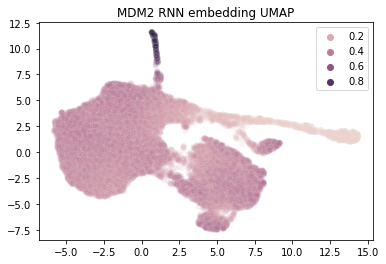

In [ ]:
# colored by predicted confidence
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_pred.numpy().reshape(-1), alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

### get samples from putative binder cluster

In [ ]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_train[i] == 0:
        if x1 > 10.0:
            true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [ ]:
len(good_seqs)

1133

In [ ]:
good_seqs

['AVCGDYAEC',
 'KDVFRDY',
 'ACLGDYACR',
 'ACVGDYAAC',
 'DYPDYAD',
 'MADSPDY',
 'ACYGDYACF',
 'AGCGDYAAG',
 'DWGDYAL',
 'AHCYGDYAC',
 'DDYLDYS',
 'ACWDYACYV',
 'ACWEGEYAC',
 'KVELRDY',
 'AFCLGDYSC',
 'NEDLMDY',
 'AECGDYAEC',
 'AYCFGDYSC',
 'ACLGDYSHC',
 'ACFDADYSEC',
 'ADCYGDYAC',
 'AKCWGDYAC',
 'AQCFGDYAC',
 'ALCGDYSAC',
 'ACGDYAVVC',
 'ACVVDYACW',
 'ACMGDYASC',
 'KDDLWDY',
 'NEDLLYY',
 'TADMPDY',
 'ACYCDYACA',
 'MKDVVDY',
 'DARDYAG',
 'KEDLSYY',
 'AGWMTWCEE',
 'ACYVDYAAC',
 'ARCVGDYGC',
 'LMDWPDY',
 'AHCGDYAEC',
 'AVWWGDYAC',
 'ASCVGDYSC',
 'DEKDYAA',
 'KVDLGDF',
 'ACYGDYAGC',
 'DLYDYAH',
 'SEVYDYS',
 'ACAADLRDY',
 'AGCYGDYDC',
 'ADRRDYA',
 'ARCVGDYAF',
 'ATCVGDYAC',
 'DTMDYAY',
 'ACTGDYAWC',
 'ACNFDYACW',
 'ALCSGDYAC',
 'ACFADYACL',
 'ACNLPWCEE',
 'RLDKPDY',
 'LADLHDY',
 'AFCVGDYAC',
 'ACLGDYACK',
 'HAVGFDY',
 'AKCFGDYAW',
 'ACAADMRDY',
 'AHCDVMDYG',
 'AFCLGEYAC',
 'ACVGDYAGC',
 'AAWGDYAAC',
 'ACYGDYACY',
 'QHDYPDY',
 'SDTGDYA',
 'ACGMTWCEE',
 'ARCYGDYDC',
 'APCADYACW',
 'ACCFDLGDY',

In [ ]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [ ]:
for seq in ninemer_seq:
    print(seq)

VCGDYAEC
CLGDYACR
CVGDYAAC
CYGDYACF
GCGDYAAG
HCYGDYAC
CWDYACYV
CWEGEYAC
FCLGDYSC
ECGDYAEC
YCFGDYSC
CLGDYSHC
DCYGDYAC
KCWGDYAC
QCFGDYAC
LCGDYSAC
CGDYAVVC
CVVDYACW
CMGDYASC
CYCDYACA
GWMTWCEE
CYVDYAAC
RCVGDYGC
HCGDYAEC
VWWGDYAC
SCVGDYSC
CYGDYAGC
CAADLRDY
GCYGDYDC
RCVGDYAF
TCVGDYAC
CTGDYAWC
CNFDYACW
LCSGDYAC
CFADYACL
CNLPWCEE
FCVGDYAC
CLGDYACK
KCFGDYAW
CAADMRDY
HCDVMDYG
FCLGEYAC
CVGDYAGC
AWGDYAAC
CYGDYACY
CGMTWCEE
RCYGDYDC
PCADYACW
CCFDLGDY
CNGDYAAF
GGLGDYAR
GCWGDYAG
DCGGYCGY
VCWGDYEC
CPCDYAAC
RCAGDYAC
CVWRWCEE
LCQGDYAC
CRATWWEE
CVGDYACA
QCYGDYSC
CVFTFCEE
CWLTWCEE
PCGDYAAC
CLGYYAAC
YCVGDYAC
CVGDYACP
VCWGDYVC
RCWDYACY
ACFGDYAW
ACFGDYAF
CWWTWCEE
CCDYAAYC
CTGDYAAC
LCYGDYAC
CFGDYASC
VCGGDYAC
GCYGDYVC
CRGDFAAC
RCYWDYAC
GCVGDYAW
VCLGDYAG
HCGDYSAC
CPDYAACF
CWDGEYAC
CWMTWGEE
LCFCDYAC
MCWGDYAC
CFGYAAYC
LCFGDYAG
CPGDYSTC
MCYGDYSC
CYGDYASC
YCFGDYAW
CYGYYAAC
CAADRLDY
CSVDYAAC
CVGDYACS
LCGDYAAC
FCHGDYAF
GWLGDYAG
ACYGDYAC
CWMRWCEE
ECLGDYAR
CYFTWCEE
WRGDYAMC
CWLRWCEE
CYGDYACR
RCVGDYSC
CGDYSATC
GCYGDYEC
G

## 12ca5

In [ ]:
y = R3_lib['12ca5_log_ratio']
y = np.array(list(y.apply(lambda e: e > 0)))
X, y = shuffle(nn_x, y, random_state=0)

### train model

In [ ]:
models = []
kf = KFold(n_splits=5)
acc, pre, rec = [], [], []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    model.fit(
        x=X_train,
        y=y_train,
        batch_size=128,
        epochs=16,
        verbose='auto',
        validation_split=0.1,
        initial_epoch=0,
        class_weight={1:0.8, 0:0.2},
        validation_freq=1,
        use_multiprocessing=False)
    
    y_pred = model(X_test)
    y_pred = y_pred.numpy().reshape(-1) >= 0.5
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print(tn, fp, fn, tp)
    print("accuracy", (tn+tp)/(tn+fp+fn+tp))
    acc.append((tn+tp)/(tn+fp+fn+tp))
    print("precision", tp/(tp+fp))
    pre.append(tp/(tp+fp))
    print("recall", tp/(tp+fn))
    rec.append(tp/(tp+fn))
    models.append(model)

# do not trust the accuracy score here, it was wrongly implemented before (it's fine now)

Epoch 1/16
360/360 [==============================] - 7s 10ms/step - loss: 0.1145 - accuracy: 0.9132 - recall_6: 0.3721 - precision_6: 0.5076 - val_loss: 0.2706 - val_accuracy: 0.9271 - val_recall_6: 0.4262 - val_precision_6: 0.6788
Epoch 2/16
360/360 [==============================] - 3s 8ms/step - loss: 0.1006 - accuracy: 0.9287 - recall_6: 0.4497 - precision_6: 0.6320 - val_loss: 0.2840 - val_accuracy: 0.9265 - val_recall_6: 0.4699 - val_precision_6: 0.6513
Epoch 3/16
360/360 [==============================] - 3s 8ms/step - loss: 0.0973 - accuracy: 0.9339 - recall_6: 0.4536 - precision_6: 0.6873 - val_loss: 0.2818 - val_accuracy: 0.9269 - val_recall_6: 0.4719 - val_precision_6: 0.6542
Epoch 4/16
360/360 [==============================] - 3s 8ms/step - loss: 0.0956 - accuracy: 0.9372 - recall_6: 0.4606 - precision_6: 0.7238 - val_loss: 0.2607 - val_accuracy: 0.9375 - val_recall_6: 0.4699 - val_precision_6: 0.7766
Epoch 5/16
360/360 [==============================] - 3s 8ms/step - los

### results

In [ ]:
kf = KFold(n_splits=5)
acc, pre, rec = [], [], []
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = models[i]
    y_pred = model(X_test)
    y_pred = y_pred.numpy().reshape(-1) >= 0.5
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(tn, fp, fn, tp)
    print("accuracy", (tn+tp)/(tn+fp+fn+tp))
    acc.append((tn+tp)/(tn+fp+fn+tp))
    print("precision", tp/(tp+fp))
    pre.append(tp/(tp+fp))
    print("recall", tp/(tp+fn))
    rec.append(tp/(tp+fn))
    
    i+=1
    if i==5:
        break

11626 85 592 494
accuracy 0.9470969758537157
precision 0.853195164075993
recall 0.4548802946593002
11468 173 602 554
accuracy 0.939438930999453
precision 0.7620357634112792
recall 0.47923875432525953
11493 200 597 506
accuracy 0.9377149109096593
precision 0.71671388101983
recall 0.4587488667271079
11566 72 638 520
accuracy 0.9445139105970616
precision 0.8783783783783784
recall 0.44905008635578586
11518 169 588 521
accuracy 0.9408408877774305
precision 0.755072463768116
recall 0.4697926059513075


In [ ]:
print(np.array(acc).mean(), np.array(acc).var())
print(np.array(pre).mean(), np.array(pre).var())
print(np.array(rec).mean(), np.array(rec).var())

0.9419211232274639 1.170648113987608e-05
0.7930791301307194 0.003825949573193828
0.46234212160375215 0.00011725489146586728


Text(0.5, 0, '12ca5_log_ratio')

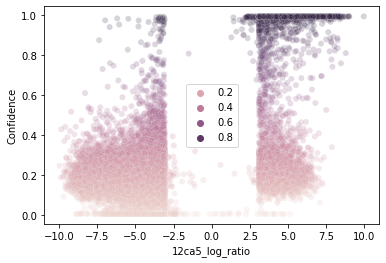

In [ ]:
# confidence analysis
ax = sns.scatterplot(x=y_12ca5_reg_train, y=y_pred.numpy().reshape(-1), hue=y_pred.numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('12ca5_log_ratio')

### umap

In [ ]:
model = models[3] # third model showed the best precision
y_pred = model(X_train)

In [ ]:
kf = KFold(n_splits=5)
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    if i==3:
        break
    i += 1

In [ ]:
nn_emb = model.layers[2](model.layers[1](model.layers[0](X_train)))
reducer = umap.UMAP(n_neighbors=10,
                    min_dist=0.1,
                    n_components=2)

In [ ]:
embedding = reducer.fit_transform(nn_emb)

Text(0.5, 1.0, '12ca5 RNN embedding UMAP')

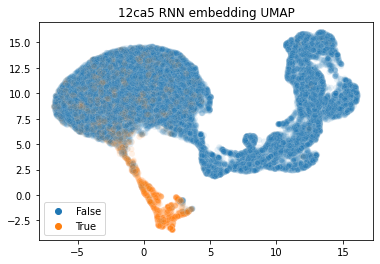

In [ ]:
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_train, alpha=0.1)
plt.title("12ca5 RNN embedding UMAP")

### find samples from the putative binder cluster

In [ ]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_train[i] == 1:
        if x2 < 1.2:
            true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [ ]:
ninemer_seq = []
for seq in ninemer_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:]) # exclude 'A' in position 0 

In [ ]:
len(good_seqs)

1689

In [ ]:
# write results
with open('12ca5_good.txt','w') as fh:
    for i in range(len(ls)):
        fh.write(f'{ls[i]}\n')

In [ ]:
good_seqs

['AFCLGDFAC',
 'AHCTDRRDY',
 'AVCGDYAEC',
 'KDVFRDY',
 'ACLGDYACR',
 'ACVGDYAAC',
 'DYPDYAD',
 'MADSPDY',
 'ACYGDYACF',
 'AGCGDYAAG',
 'DWGDYAL',
 'KVDFRVY',
 'AHCYGDYAC',
 'DDYLDYS',
 'ACWEGEYAC',
 'KVELRDY',
 'AFCLGDYSC',
 'NEDLMDY',
 'YDNPDYS',
 'AECGDYAEC',
 'AYCFGDYSC',
 'ACLGDYSHC',
 'ACFDADYSEC',
 'ADCYGDYAC',
 'AKCWGDYAC',
 'ARCVGVYAC',
 'AQCFGDYAC',
 'ALCGDYSAC',
 'AGCRMLECR',
 'LVDLRVY',
 'ACGDYAVVC',
 'ACVVDYACW',
 'SNVYDYS',
 'ACMGDYASC',
 'AVCTYLECK',
 'KDDLWDY',
 'NEDLLYY',
 'TADMPDY',
 'ATCLDYACW',
 'APCFHLEWR',
 'APCFHLECR',
 'MKDVVDY',
 'ACNFSLCEE',
 'DARDYAG',
 'KEDLSYY',
 'AGWMTWCEE',
 'ACYVDYAAC',
 'ARCVGDYGC',
 'LMDWPDY',
 'AHCGDYAEC',
 'AVWWGDYAC',
 'ASCVGDYSC',
 'DEKDYAA',
 'AKCWGDFAC',
 'KVDLGDF',
 'ACSYTWWEE',
 'ACYGDYAGC',
 'ACSGYYAAC',
 'ACWVYACME',
 'AVCFHLECR',
 'DLYDYAH',
 'AVCSMLECK',
 'SEVYDYS',
 'ACAADLRDY',
 'DVPDYAM',
 'AGCYGDYDC',
 'ADRRDYA',
 'ARCVGDYAF',
 'ATCVGDYAC',
 'DTMDYAY',
 'ACTGDYAWC',
 'MLDLLYV',
 'ACNFDYACW',
 'ALCSGDYAC',
 'ACFADYACL',
 

In [ ]:
for seq in ninemer_seq:
    print(seq)

FCLGDFAC
HCTDRRDY
VCGDYAEC
CLGDYACR
CVGDYAAC
CYGDYACF
GCGDYAAG
HCYGDYAC
CWEGEYAC
FCLGDYSC
ECGDYAEC
YCFGDYSC
CLGDYSHC
DCYGDYAC
KCWGDYAC
RCVGVYAC
QCFGDYAC
LCGDYSAC
GCRMLECR
CGDYAVVC
CVVDYACW
CMGDYASC
VCTYLECK
TCLDYACW
PCFHLEWR
PCFHLECR
CNFSLCEE
GWMTWCEE
CYVDYAAC
RCVGDYGC
HCGDYAEC
VWWGDYAC
SCVGDYSC
KCWGDFAC
CSYTWWEE
CYGDYAGC
CSGYYAAC
CWVYACME
VCFHLECR
VCSMLECK
CAADLRDY
GCYGDYDC
RCVGDYAF
TCVGDYAC
CTGDYAWC
CNFDYACW
LCSGDYAC
CFADYACL
CWDYACWP
CNLPWCEE
GCPMLECK
CRSTWCEE
FCVGDYAC
CLGDYACK
VCPMLECQ
TCFLLECK
KCFGDYAW
CAADMRDY
HCDVMDYG
PCTLMECR
FCLGEYAC
CQHTSCEE
CVGDYAGC
AWGDYAAC
CYGDYACY
CGMTWCEE
RCYGDYDC
PCADYACW
CCFDLGDY
CNGDYAAF
GGLGDYAR
CVGDSACQ
SCFVYACW
GCWGDYAG
HCFHLECR
TCFHLECR
NCTLLECR
YCTLLECR
VCWGDYEC
CPCDYAAC
PCLLLECK
RCAGDYAC
CVWRWCEE
LCQGDYAC
CFAYQCEE
CRATWWEE
CVGDYACA
QCYGDYSC
CVFTFCEE
CWLTWCEE
CSNTLCEE
PCGDYAAC
GCLGDFAC
CLGYYAAC
YCVGDYAC
CVGDYACP
VCWGDYVC
ACFGDYAW
ACFGDYAF
VCPMLECR
CWWTWCEE
CTGDYAAC
LCYGDYAC
CFGDYASC
VCGGDYAC
CFGVYAAC
GCYGDYVC
CDYADQSC
QCFMLECR
CSNTGCEE
RCYWDYAC
C

### 3mer frequency detection

In [ ]:
Dict_3mer_occ = {}
for tmer in Dict_3mer_to_100vec.keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('ACG', 83),
 ('CLG', 85),
 ('LRD', 88),
 ('PDY', 88),
 ('CGD', 106),
 ('DLR', 107),
 ('RDY', 118),
 ('LEC', 120),
 ('LGD', 123),
 ('AAC', 123),
 ('YAA', 139),
 ('DYS', 171),
 ('YAC', 314),
 ('GDY', 552),
 ('DYA', 589)]

In [ ]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 589)
('GDY', 552)
('YAC', 314)
('DYS', 171)
('YAA', 139)
